# <center><b> Wright's law and Moore's law calibration, and example forecasts </b></center>

This jupyter notebook is associated with the paper "Empirically grounded technology forecasts and the energy transition", by Way et al. 2022, in Joule, Volume 6, Issue 9, 2057 - 2082 

The purpose of this notebook is to display technology data and calibrate the Wright's law and Moore's law models used in the paper for each technology

Everything here was done by Rupert Way

Included so far:
1. Solar PV electricity (Section 6.11 in the S.I.)
2. Wind electricity (Section 6.10 in the S.I.)
3. Batteries (Section 6.12 in the S.I.)
4. Electrolyzers (Section 6.13 in the S.I.)

Yet to be added:

5. Nuclear electricity
6. Hydropower
7. Biopower


In [355]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import mode
from scipy.special import erfinv
from cycler import cycler
from matplotlib import cm
import seaborn as sns
import importlib
import sys

sns.set_style('whitegrid')
np.set_printoptions(linewidth=300, precision=3)

In [356]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [357]:
# display raw tech data file
df = pd.read_excel('./tech_data.xlsx', index_col=0)
df

,Technology,Solar PV experience,Solar PV cost,Wind experience,Wind cost,Batteries experience,Batteries cost,PEM electrolyzers experience,PEM electrolyzers cost
Year,,,,,,,,,
NaN,Variable,Experience,Cost,Experience,Cost,Experience,Cost,Experience,Cost
NaN,Metric,Cumulative electricity generation,LCOE,Cumulative electricity generation,LCOE,Cumulative production,Cost,Cumulative production,System cost
NaN,Unit,TWh,$(2020)/MWh,TWh,$(2020)/MWh,GWh,$(2020)/kWh,MW,$(2020)/kW
NaN,NaN,"PCDB IEA PV cumul gen, TWh","Global LCOE, real$/MWh","IEA + Wiser wind cumul gen, TWh",IRENA LCOE 2020$/MWh,"Final2 Cum. Prod., GWh",EVO BNEF real$/kWh,"IEA2021 PEM cumul installs1, MW","GMR IEA PEM cost, 2020$/kW"
1850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2016.0,NaN,1164.454626,103.829515,5742.335716,60.275007,415.308333,267.002922,13.447808,1866.170856
2017.0,NaN,1607.854626,83.433463,6869.335716,57.667646,540.308333,221,14.035408,1590.900535
2018.0,NaN,2196.654626,70.430687,8141.335716,50.356839,700.308333,181,31.608208,1202.28361


# Select technology for calibration

In [358]:
# pick technology to calibrate and plot, get columns names

# select exactly one technology from list:
tech_name = [
    'Solar PV',
    #'Wind',
    #'Batteries',
    #'PEM electrolyzers',
]
if len(tech_name) > 1: print("Pick one tech only"); sys.exit()

# import full tech data file for grabbing correct tech column names
df = pd.read_excel('./tech_data.xlsx', index_col=0)

for col in df.columns:
    if col == tech_name[0] + ' experience':
        col_name_experience = df[tech_name[0] + ' experience'].iloc[3]
    if col == tech_name[0] + ' cost': 
        col_name_cost = df[tech_name[0] + ' cost'].iloc[3]

# reload tech data file skipping header rows
df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)

# Wright's law model calibration

In [359]:
# make neat dataframe of [time, experience, cost]
df_temp1 = pd.DataFrame(df[col_name_experience])    # form new dataframe for experience column
df_temp1 = df_temp1.dropna()
df_temp2 = pd.DataFrame(df[col_name_cost])          # form new dataframe for unit cost column
df_temp2 = df_temp2.dropna()
df = pd.concat([df_temp1, df_temp2], axis=1)        # merge dataframes in a single dataframe using matched year as index
del df_temp1, df_temp2
df = df.dropna()

t_series = df.index.values                         # extract matched year data from index
x_series = df[col_name_experience].values          # extract matched experience data
y_series = df[col_name_cost].values                # extract matched cost data

# specify example future experience to make example forecast
T=10
prod_growth_rate = 0.2
last_production = x_series[-1]-x_series[-2]
production_future = np.array([last_production*(1+prod_growth_rate)**(t+1) for t in range(T)])
cumul_prod_future = production_future.cumsum()
x_future = x_series[-1] + cumul_prod_future

x_label = col_name_experience
y_label = col_name_cost

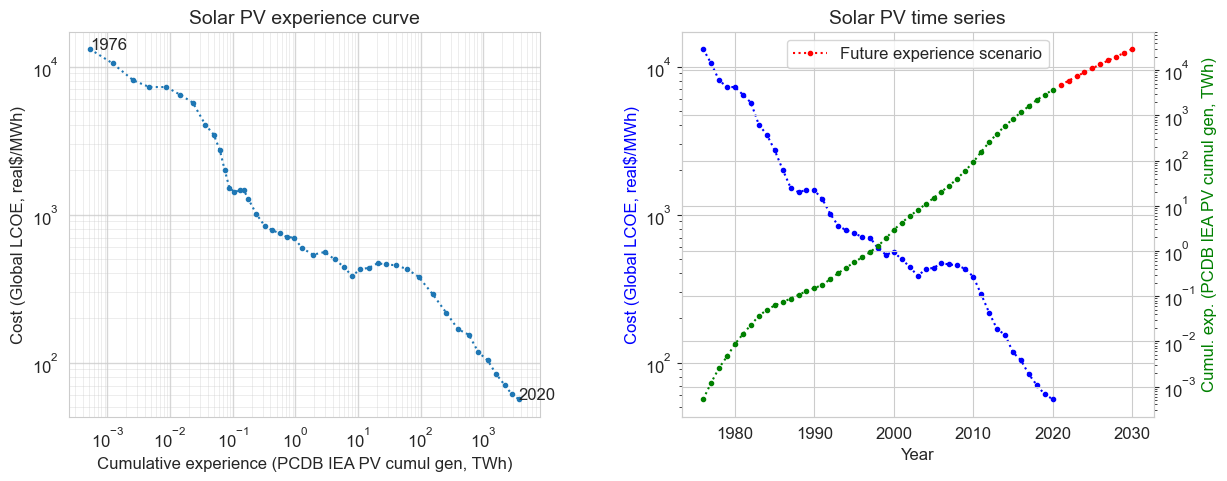

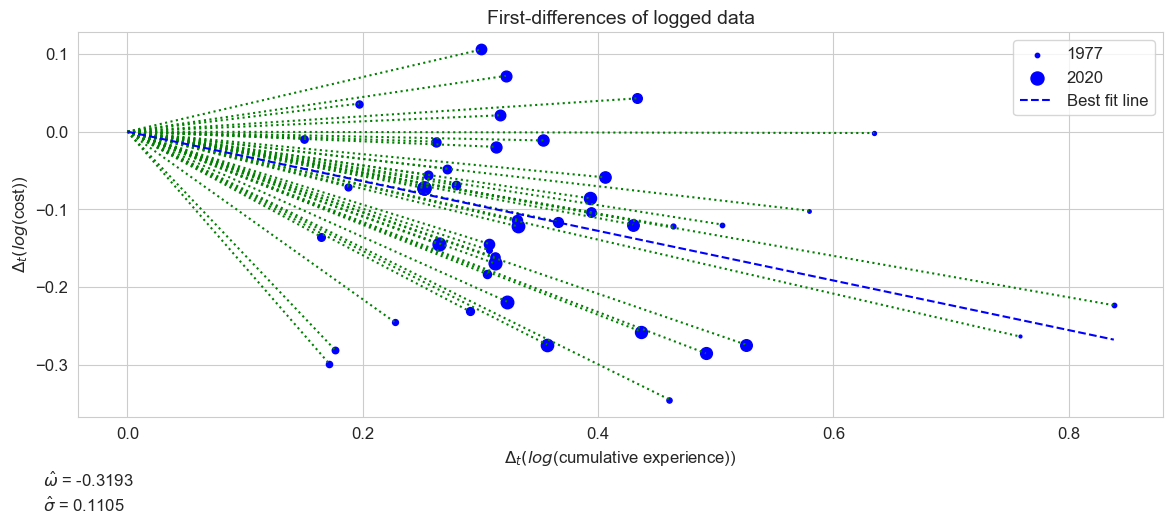

omega_hat = -0.3192782651126454
omega_hat_se = 0.043093804840444165
sigma_hat = 0.11050487915944429


In [360]:
params = {'figure.figsize': (14, 5), # (width, height)
         'axes.titlesize': 14,
         'legend.fontsize': 12,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12
         }
plt.rcParams.update(params)
annotation_fontsize = 12
axes_label_fontsize = 12

fig = plt.figure()
ax1 = fig.add_subplot(121)    # experience curve plot
ax2 = fig.add_subplot(122)    # time series plot

# plot experience curve
ax1.plot(x_series, y_series, '.:')
ax1.annotate(str(t_series[0]), xy=(x_series[0], y_series[0]), fontsize=annotation_fontsize)        # first point label
ax1.annotate(str(t_series[-1]), xy=(x_series[-1], y_series[-1]), fontsize=annotation_fontsize)     # last point label
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Cumulative experience ('+x_label+')', fontsize=axes_label_fontsize)
ax1.set_ylabel('Cost ('+y_label+')', fontsize=axes_label_fontsize)
ax1.set_title(tech_name[0]+' experience curve')
ax1.grid(True, which='major', axis='both', lw=1, alpha=0.8)
ax1.grid(True, which='minor', axis='both', lw=0.5, alpha=0.5)

# plot experience and cost time series
ax2.plot(t_series, y_series, '.:', color='b')    # plot cost
ax2.set_ylabel('Cost ('+y_label+')', color='b', fontsize=axes_label_fontsize)
ax2.set_yscale('log')
ax2.set_xlabel('Year', fontsize=axes_label_fontsize)
ax2.set_title(tech_name[0]+' time series')

ax3 = ax2.twinx()    # twin axis to plot experience
ax3.plot(t_series, x_series, '.:', color='g')
ax3.plot(range(len(x_future))+t_series[-1]+1, x_future, '.:', color='r', label='Future experience scenario')
ax3.set_yscale('log')
ax3.set_ylabel('Cumul. exp. ('+x_label+')', color='g', fontsize=axes_label_fontsize)
ax3.legend(loc='upper center')
plt.subplots_adjust(wspace=0.3)
plt.show()


# step through t_series, appending delta log x and y iff year delta is 1
delta_log_x_series = []
delta_log_y_series = []
for t in range(1, len(t_series)):
    if t_series[t] - t_series[t-1] - 1 < 1e-8:
        delta_log_x_series.append(np.log(x_series[t]) - np.log(x_series[t-1]))
        delta_log_y_series.append(np.log(y_series[t]) - np.log(y_series[t-1]))

delta_log_x_series = np.array(delta_log_x_series)
delta_log_y_series = np.array(delta_log_y_series)

# main Wright's law model calibration: regression through origin
OLS_results = sm.OLS(delta_log_y_series, delta_log_x_series).fit()    # regress Y on X here, hence order of args in function
omega_hat = OLS_results.params[0]
omega_hat_se = OLS_results.bse[0]         # standard error
sigma_hat = np.sqrt(OLS_results.scale)    # nb. scale is the _variance_ of the residuals

# plot delta logs
fig = plt.figure()
for t in range(len(delta_log_x_series)):
    plt.plot([0.0, delta_log_x_series[t]], [0, delta_log_y_series[t]], ':', color='g')    # NB. "plt.plot([x1, x2], [y1,y2])" draws a line (x1,y1) -> (x2,y2)
    plt.scatter(delta_log_x_series[t], delta_log_y_series[t], color='b', s=2*(t+1))
    if t == 0: plt.scatter(delta_log_x_series[t], delta_log_y_series[t], color='b', s=2*(t+5), label=str(t_series[1]))           # label first and last points
    if t == len(delta_log_x_series)-1: plt.scatter(delta_log_x_series[t], delta_log_y_series[t], color='b', s=2*(t+1), label=str(t_series[-1]))

# plot best fit line
x_coord_of_OLS_line_end = max(delta_log_x_series)    # x coord of end point of the OLS best fit line
plt.plot([0.0, x_coord_of_OLS_line_end], [0, omega_hat*x_coord_of_OLS_line_end], '--', color='b', label='Best fit line')
plt.legend()
plt.xlabel(r'$\Delta_t(log$(cumulative experience))', fontsize=axes_label_fontsize)
plt.ylabel(r'$\Delta_t(log$(cost))', fontsize=axes_label_fontsize)
plt.title('First-differences of logged data')
plt.figtext(0.1, -0.03, r'$\hat{\omega}$ = ' + str(round(omega_hat, 4)), fontsize=annotation_fontsize)
plt.figtext(0.1, -0.08, r'$\hat{\sigma}$ = ' + str(round(sigma_hat, 4)), fontsize=annotation_fontsize)
plt.show()

print('omega_hat =', omega_hat)
print('omega_hat_se =', omega_hat_se)
print('sigma_hat =', sigma_hat)


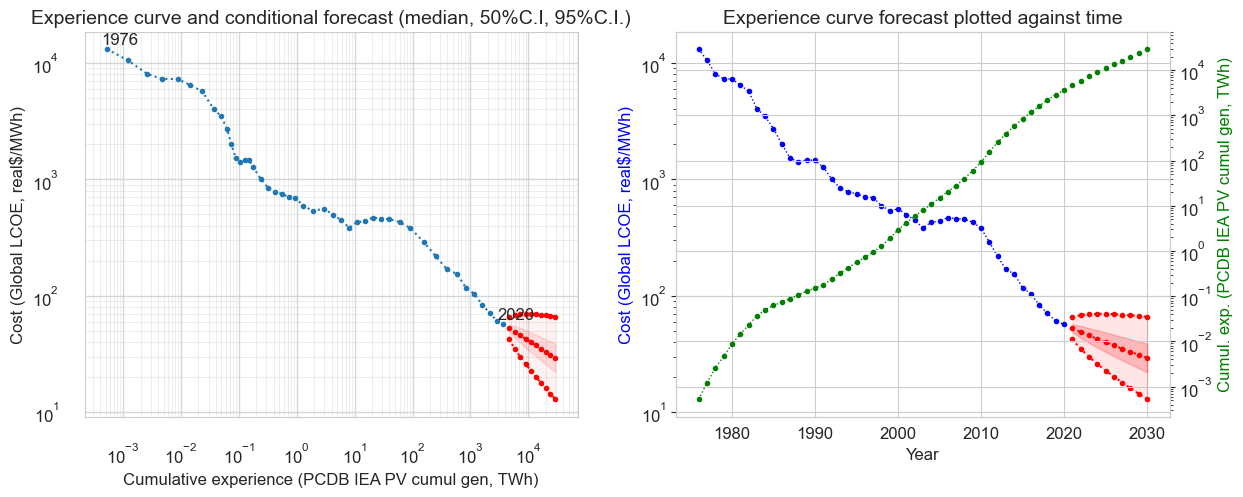

In [361]:
# compute forecasts
point_forecast = []
FEV = []                    # Forecast Error Variance with no autocorrelation (Eq. 13 in "How well do experience curves...")
FEV_autocorrelation = []    # Forecast Error Variance with autocorrelation (Eq. 27)
FEV_approx = []             # Forecast Error Variance approximation (Eq. 29)
forecast_LB95 = []
forecast_LB50 = []
forecast_UB95 = []
forecast_UB50 = []
delta_log_x_future = []
delta_log_x_future.append(np.log(x_future[0]) - np.log(x_series[-1]))
for tau in range(1, len(x_future)):
    delta_log_x_future.append( np.log(x_future[tau]) - np.log(x_future[tau-1]) )
delta_log_x_future = np.array(delta_log_x_future)

rho = 0.19    # average of all techs from "How well do experience curves..."
sigma_hat_autocorrelation = np.sqrt((sigma_hat**2 / (1+rho**2)))

for tau in range(len(x_future)):

    H = []
    for t in range(len(delta_log_x_series)):
        H.append(-sum(delta_log_x_future[:tau+1]) * delta_log_x_series[t] /(delta_log_x_series.dot(delta_log_x_series))  )

    inside_sum = 0
    for t in range(len(delta_log_x_series)-1):
        inside_sum += (H[t] + rho*H[t+1])**2

    # FEV_autocorrelation
    FEV_autocorrelation_time_factor = (rho**2)*(H[0]**2) + inside_sum + (rho+H[-1])**2 + tau*(1+rho)**2 + 1
    FEV_autocorrelation.append((sigma_hat**2)*FEV_autocorrelation_time_factor/(1+rho**2))    # Eq. 27

    # FEV
    FEV_time_factor = tau+1 + ((sum(delta_log_x_future[:tau+1]))**2)/(delta_log_x_series.dot(delta_log_x_series))       # Eq. 13
    FEV.append(sigma_hat**2 * FEV_time_factor)

    # FEV_approx
    FEV_approx_time_factor = tau+1 + ( (tau+1)**2 / (len(delta_log_x_series)) )
    FEV_approx.append( sigma_hat**2 * (1+rho)**2 * FEV_approx_time_factor /(1+rho**2)  )    # Eq. 29

    point_forecast.append(y_series[-1] * ( x_series[-1] / x_future[tau] )**(-omega_hat))

    p = 0.025
    #p = 0.02275 # 2sd
    p_quantile = np.sqrt(FEV_autocorrelation[tau]) * np.sqrt(2) * erfinv(2*p -1)
    forecast_LB95.append( point_forecast[tau] * np.exp(p_quantile)  )

    p = 0.975
    #p = 0.97725 # 2sd
    p_quantile = np.sqrt(FEV_autocorrelation[tau]) * np.sqrt(2) * erfinv(2*p -1)
    forecast_UB95.append( point_forecast[tau] * np.exp(p_quantile)  )

    p = 0.25
    p_quantile = np.sqrt(FEV_autocorrelation[tau]) * np.sqrt(2) * erfinv(2*p -1)
    forecast_LB50.append( point_forecast[tau] * np.exp(p_quantile)  )

    p = 0.75
    p_quantile = np.sqrt(FEV_autocorrelation[tau]) * np.sqrt(2) * erfinv(2*p -1)
    forecast_UB50.append( point_forecast[tau] * np.exp(p_quantile)  )


# plot experience curve forecasts
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(x_series, y_series, '.:')
ax1.plot(x_future, point_forecast, ':.r')
ax1.plot(x_future, forecast_LB95, ':.r')
ax1.plot(x_future, forecast_UB95, ':.r')
ax1.fill_between(x_future, forecast_LB95, forecast_UB95, color='r', alpha=0.05)
ax1.fill_between(x_future, forecast_LB50, forecast_UB50, color='r', alpha=0.1)
ax1.annotate(str(t_series[0]), xy=(0.8*x_series[0], 1.1*y_series[0]), fontsize=annotation_fontsize)        # first point label
ax1.annotate(str(t_series[-1]), xy=(0.8*x_series[-1], 1.1*y_series[-1]), fontsize=annotation_fontsize)     # fifth-last point label
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.grid(True, which='major', axis='both', lw=1, alpha=0.8)
ax1.grid(True, which='minor', axis='both', lw=0.5, alpha=0.5)
ax1.tick_params(axis='both', which='major', pad=15)

ax1.set_xlabel('Cumulative experience ('+x_label+')', fontsize=axes_label_fontsize)
ax1.set_ylabel('Cost ('+y_label+')', fontsize=axes_label_fontsize)
ax1.set_title('Experience curve and conditional forecast (median, 50%C.I, 95%C.I.)')

# plot experience curve forecasts against time
ax2.plot(t_series, y_series, '.:', color='b', lw=1)
ax2.set_ylabel('Cost ('+y_label+')', color='b', fontsize=axes_label_fontsize)
ax2.set_yscale('log')
ax2.set_xlabel('Year', fontsize=axes_label_fontsize)
ax2.plot(range(len(x_future))+t_series[-1]+1, point_forecast, '.:', color='r')
ax2.plot(range(len(x_future))+t_series[-1]+1, forecast_UB95, '.:', color='r')
ax2.plot(range(len(x_future))+t_series[-1]+1, forecast_LB95, '.:', color='r')
ax2.fill_between(range(len(x_future))+t_series[-1]+1, forecast_LB95, forecast_UB95, color='r', alpha=0.1)
ax2.fill_between(range(len(x_future))+t_series[-1]+1, forecast_LB50, forecast_UB50, color='r', alpha=0.2)
ax2.set_title('Experience curve forecast plotted against time')

ax3 = ax2.twinx()
ax3.plot(t_series, x_series, '.:', color='g', lw=1)
ax3.plot(range(len(x_future))+t_series[-1]+1, x_future, '.', color='g')
ax3.set_yscale('log')
ax3.set_ylabel('Cumul. exp. ('+x_label+')', color='g', fontsize=axes_label_fontsize)

plt.show()


# Wright and Moore law model calibration

In [362]:
# calibrate Wright and Moore laws in one go

df_results = pd.DataFrame(columns=['Wright: omega_hat', 'Wright: omege_hat_se', 'Wright: sigma_eta', 'Moore (part): mu_hat', 'Moore (part): sigma_mu', 'Moore (part) K', 'Moore (full): mu_hat_v2', 'Moore (full): sigma_mu_v2', 'Moore (full): K_v2'])

# Moore version 1 (best) : use only time points at which both cost and productin are available

# import full tech data again
df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)

# make neat dataframe of [time, experience, cost]
df_temp1 = pd.DataFrame(df[col_name_experience])    # form new dataframe for experience column
df_temp1 = df_temp1.dropna()
df_temp2 = pd.DataFrame(df[col_name_cost])          # form new dataframe for unit cost column
df_temp2 = df_temp2.dropna()
df = pd.concat([df_temp1, df_temp2], axis=1)        # merge dataframes in a single dataframe using matched year as index
del df_temp1, df_temp2
df = df.dropna()

t_series = df.index.values                         # extract matched year data from index
x_series = df[col_name_experience].values          # extract matched experience data
y_series = df[col_name_cost].values                # extract matched cost data

# step through t_series, appending delta log x and y iff year delta is 1
delta_log_x_series = []
delta_log_y_series = []
delta_t_series = []
for t in range(1, len(t_series)):
    if t_series[t] - t_series[t-1] - 1 < 1e-8:
        delta_log_x_series.append(np.log(x_series[t]) - np.log(x_series[t-1]))
        delta_log_y_series.append(np.log(y_series[t]) - np.log(y_series[t-1]))
        delta_t_series.append(1)

delta_log_x_series = np.array(delta_log_x_series)
delta_log_y_series = np.array(delta_log_y_series)
delta_t_series = np.array(delta_t_series)

# main Wright's law model calibration: regression through origin
OLS_results = sm.OLS(delta_log_y_series, delta_log_x_series).fit()    # regress Y on X here, hence order of args in function
omega_hat = OLS_results.params[0]
omega_hat_se = OLS_results.bse[0]         # standard error
sigma_hat = np.sqrt(OLS_results.scale)    # nb. scale is the _variance_ of the residuals
rho = 0.19    # average of all techs from paper
sigma_hat_autocorrelation = np.sqrt((sigma_hat**2 / (1+rho**2)))    # i.e. sigma_u in paper


# main Moore's law model calibration: regression through origin (only using time points at which both x and y are available)
OLS_results_moore = sm.OLS(delta_log_y_series, delta_t_series).fit()
mu_hat = -OLS_results_moore.params[0]
sigma_mu = OLS_results_moore.bse[0]
K = np.sqrt(OLS_results_moore.scale)
theta=0.63
sigma_v = K/(np.sqrt(1+theta**2))

#---------------------
# Moore version 2 : use all time points

df = pd.read_excel('./tech_data.xlsx', index_col=0, skiprows=4)

df_temp2 = pd.DataFrame(df[col_name_cost])          # form new dataframe for unit cost column
df_temp2 = df_temp2.dropna()
df = pd.concat([df_temp2], axis=1)        # merge dataframes in a single dataframe using matched year as index
del df_temp2
df = df.dropna()
t_series = df.index.values                         # extract matched year data from index
y_series = df[col_name_cost].values                # extract matched cost data

# step through t_series, appending delta log y iff year delta is 1
delta_log_y_series = []
delta_t_series = []
for t in range(1, len(t_series)):
    if t_series[t] - t_series[t-1] - 1 < 1e-8:
        delta_log_y_series.append(np.log(y_series[t]) - np.log(y_series[t-1]))
        delta_t_series.append(1)

delta_log_y_series = np.array(delta_log_y_series)
delta_t_series = np.array(delta_t_series)

# secondary Moore's law model calibration: regression through origin (using all time points)
OLS_results_moore = sm.OLS(delta_log_y_series, delta_t_series).fit()
mu_hat_v2 = -OLS_results_moore.params[0]
sigma_mu_v2 = OLS_results_moore.bse[0]
K_v2 = np.sqrt(OLS_results_moore.scale)
theta=0.63
sigma_v2 = K_v2/(np.sqrt(1+theta**2))
#print(OLS_results_moore.summary())

#---------------------

df_results.loc[col_name_cost] = omega_hat, omega_hat_se, sigma_hat, mu_hat, sigma_mu, K, mu_hat_v2, sigma_mu_v2, K_v2
df_results


,Wright: omega_hat,Wright: omege_hat_se,Wright: sigma_eta,Moore (part): mu_hat,Moore (part): sigma_mu,Moore (part) K,Moore (full): mu_hat_v2,Moore (full): sigma_mu_v2,Moore (full): K_v2
"Global LCOE, real$/MWh",-0.319278,0.043094,0.110505,0.123732,0.016607,0.110155,0.138751,0.012734,0.101069
